# Implementation of power law exponential decay

Define necessary packages and data:

In [16]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
import scipy
from itertools import cycle
cycol = cycle('bgrcmk')

# Read data
df = pd.read_csv("SampleSizeShiny/data/pearson_pval_0.05_num_edges_vs_num_samples.txt", sep=",")
#df = pd.read_csv("../data/out/tables/pearson_pval_0.05_num_edges_vs_num_samples.txt", sep=",")
print(os. getcwd())
numbers_complete_graph_df = pd.read_csv("SampleSizeShiny/data/dataset_numbers_complete_graph.txt", sep=",")
print(numbers_complete_graph_df)

/home/j.aguirreplans/Projects/Scipher/SampleSize/scripts
                    dataset  total_num_nodes  total_num_edges
0  scipher:complete.dataset            13822         95516931
1                 tcga:TCGA            18884        178293286
2            tcga:TCGA-BRCA            19378        187743753
3            tcga:TCGA-UCEC            17951        161110225
4          gtex:Whole.Blood            10251         52536375


Define function to calculate power law exponential decay:

In [2]:
def sol(N,a,b):
    y=np.exp((np.exp(b)*N**(1+a))/(a+1))
    y=y/max(y)
    return y


Define function to calculate the plots of the analytical model:

In [3]:
def grad(df):
    dataset=set(df.dataset) # Different datasets
    sample_number=set(df.rep) # Different numbrer of samples per size (repetitions)
    plt.figure()
    for data in dataset:

        n_samples_l=[]
        sign_edges_l=[]
 
        # Get size and significant edges for each repetition
        for sample in sample_number:
            data_bool=df.dataset==data
            sample_bool=df.rep==sample
            current=df[data_bool&sample_bool]
            sign_edges_l.append(current.num_edges)
            n_samples_l.append(current['size'])
           
        # Calculate the gradient: the ratio between the difference of consecutive samples and the difference of consecutive significant edges
        # Before calculating the gradient, we calculate the mean between different repetitions
        grad=1/(np.diff(np.mean(n_samples_l,axis=0))/np.diff(np.mean(sign_edges_l,axis=0)))
        # The gradient is divided by the significant edges to obtain the fraction gradient
        frac_grad=grad/np.mean(sign_edges_l,axis=0)[1:]
        # Check which factions are negative so that we ignore them. 
        # Why? Because some consecutive differences might give negative values! 
        # This does not make sense in theory, and as the number of situations like this is very small, we ignore it.
        boo=frac_grad>0 
        normx=np.mean(n_samples_l,axis=0)
        # Calculate polynomial fit between logarithm of sample size and logarithm of fraction gradient
        # we obtain a list with the coefficient estimates of the polynomial
        para=np.polyfit( np.log(normx[1:][boo]),np.log(frac_grad[boo]), 1, rcond=None, full=False, w=None, cov=False)
        # Keep the coefficient estimates in a polynomial form
        p = np.poly1d(para)
        # Make prediction: y = exp(pol(ln(x)))
        y=np.exp(p(np.log(normx[1:][boo])))
        plt.figure()
        normx=np.mean(n_samples_l,axis=0)
        normy=np.mean(sign_edges_l,axis=0)
        plt.plot(normx,normy,'o',label=data,c=next(cycol))
        a,b=para
        y=sol(normx,a,b)
        plt.plot(normx,y,'-',c=next(cycol),label='Model prediction')
        #plt.plot(normx,y*np.max(normy),'-',c=next(cycol),label='Model prediction') # To un-normalize results, we multiply y by the maximum value in normy
        plt.legend()


Plot the analytical model

<Figure size 432x288 with 0 Axes>

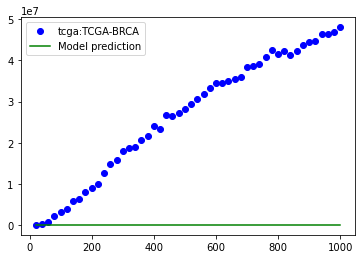

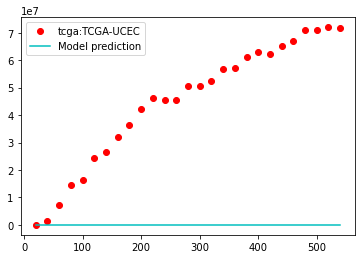

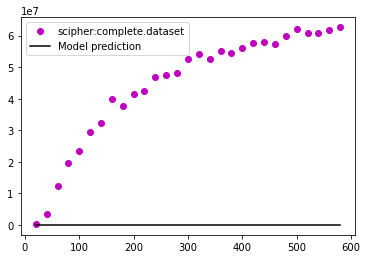

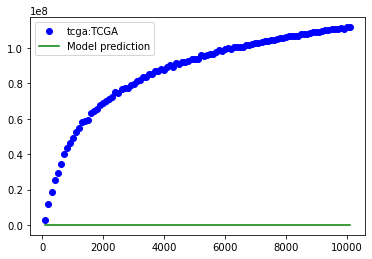

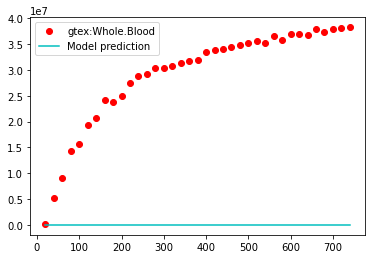

In [4]:
grad(df)

## New method to calculate function

The new method is based on optimizing the smax.

Define function to find smax:

In [5]:
def find_s_max(s,N):
    """
    Finds the linear fit between ln(smax)-ln(s) and ln(N) that has the minimum value of 1-R**2, 
    thus being the most linear relationship.
    Returns the value of smax and the linear fit obtained using the value of smax.
    """
    s_max_guess=10
    def linear_fit(s_max):
        """
        Function that searches the linear fit between ln(smax)-ln(s) and ln(N).
        It returns the difference between 1 and the result of R squared.
        The minimum is the value of 1-R**2, the more linear that the regression is.
        """
        # Calculate ln(smax)-ln(s)
        s_rec=np.log(s_max)-np.log(s)
        # Calculate linear regression between ln(smax)-ln(s) and ln(N)
        # res contains the result of the linear regression, which looks as the following one:
        # LinregressResult(slope=-0.7905116810384566, intercept=4.298613423104628, rvalue=-0.9974670475972611, pvalue=3.169429571029762e-30, stderr=0.011274390068217979, intercept_stderr=0.06144138369026198)
        res = scipy.stats.linregress(np.log(N),np.log(s_rec))
        # The function returns the result of 1-R**2
        return 1-res.rvalue**2
    # This function minimizes the value of 1-R**2 which results from the linear regression of ln(smax)-ln(s) and ln(N)
    res = scipy.optimize.minimize(linear_fit, s_max_guess,method='Nelder-Mead',
               options={'xatol': 1e-8, 'disp': True})
    # res.x is the smax value that results from the of the minimization
    s_max=res.x
    s_rec=np.log(s_max)-np.log(s)
    # This is the linear fit containing smax
    fitted = scipy.stats.linregress(np.log(N),np.log(s_rec))
    print(fitted)
    return s_max,fitted


Define new function to plot analytical model: 

In [6]:
def grad(df):
    dataset=set(df.dataset)
    sample_number=set(df.rep)      
    plt.figure()
   
    for data in dataset:
        n_samples_l=[]
        sign_edges_l=[]      
        for sample in sample_number:
            data_bool=df.dataset==data
            sample_bool=df.rep==sample
            current=df[data_bool&sample_bool]
            sign_edges_l.append(current.num_edges)
            n_samples_l.append(current['size'])
        
        # Calculate mean of samples and mean of significant edges for each sample size
        normx=np.mean(n_samples_l,axis=0)
        normy=np.mean(sign_edges_l,axis=0)

        plt.figure()
        # Find smax and linear fit from smax
        smax,res=find_s_max(normy/np.max(normy),normx)
        # Get coefficients from linear fit of smax
        a=res.slope
        b=res.intercept
        # Calculate values of y using the optimized smax (y is the same as s)
        y=np.exp(np.log(smax)-np.exp(b+a*np.log(normx)))
        # Calculate fraction y/smax
        percent=y/smax
        print(data, smax, np.max(normy)*max(percent)/(20000)**2)# Predicting the fractions. Fraction = max value of s / total num of edges in complete graph
        # Plot sample size vs normalized s
        plt.plot(normx,normy/np.max(normy),'o',label=data,c=next(cycol))
        # Plot sample size vs prediction of s
        plt.plot(normx,y,'-',c=next(cycol),label='Model prediction')
        plt.legend()
        plt.ylabel(r' $s/s_{max}$')
        plt.xlabel('N')
        
        # Plot semilog of sample size vs prediction of s
        #plt.figure()
        #plt.semilogx(normx,percent,'o')

Plot the analytical models using the new function:

Optimization terminated successfully.
         Current function value: 0.002224
         Iterations: 32
         Function evaluations: 68
LinregressResult(slope=-0.47831937915716904, intercept=3.6209486228295233, rvalue=-0.9988874372461403, pvalue=2.4560107912585627e-65, stderr=0.003259396797083695, intercept_stderr=0.019653770334280223)
tcga:TCGA-BRCA [3.97626972] 0.03046521254482119
Optimization terminated successfully.
         Current function value: 0.005059
         Iterations: 35
         Function evaluations: 72
LinregressResult(slope=-0.7905117248002399, intercept=4.298613577559953, rvalue=-0.9974670475972608, pvalue=3.1694295710349426e-30, stderr=0.011274390692355507, intercept_stderr=0.06144138709158774)
tcga:TCGA-UCEC [1.66226804] 0.1081530193203721


/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/functio

Optimization terminated successfully.
         Current function value: 0.005582
         Iterations: 36
         Function evaluations: 73
LinregressResult(slope=-0.97265203283694, intercept=4.6625727165159825, rvalue=-0.9972051240059192, pvalue=5.82062645078188e-32, stderr=0.01402438168212715, intercept_stderr=0.07735986910123711)
scipher:complete.dataset [1.23654327] 0.12604220421716975
Optimization terminated successfully.
         Current function value: 0.000919
         Iterations: 35
         Function evaluations: 72
LinregressResult(slope=-0.4898059893727059, intercept=3.5895356460892236, rvalue=-0.9995402841697753, pvalue=3.912844273290575e-152, stderr=0.0014931931899555034, intercept_stderr=0.01239918138874258)
tcga:TCGA [1.47919227] 0.18793374171273455
Optimization terminated successfully.
         Current function value: 0.006619
         Iterations: 37
         Function evaluations: 74
LinregressResult(slope=-0.9213224469100059, intercept=4.281681964261973, rvalue=-0.996685

/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


<Figure size 432x288 with 0 Axes>

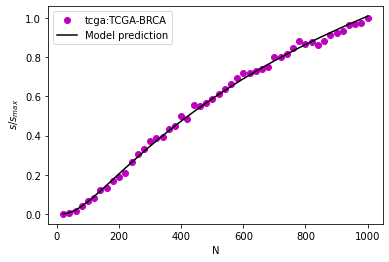

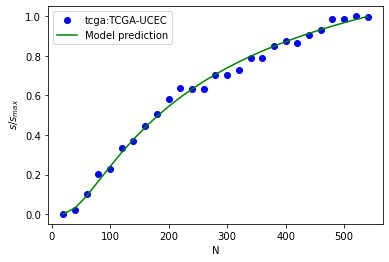

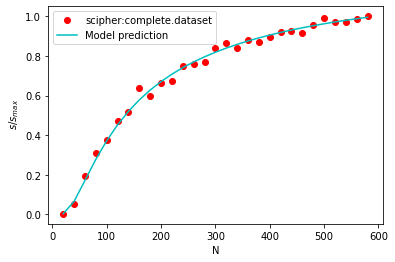

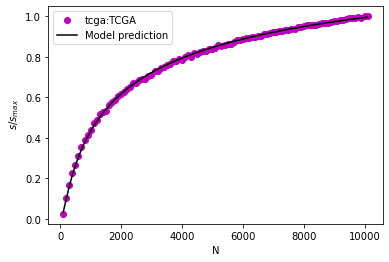

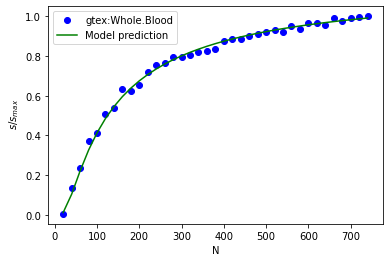

In [7]:
grad(df)

Optimization terminated successfully.
         Current function value: 0.002224
         Iterations: 32
         Function evaluations: 68
LinregressResult(slope=-0.47831937915716904, intercept=3.6209486228295233, rvalue=-0.9988874372461403, pvalue=2.4560107912585627e-65, stderr=0.003259396797083695, intercept_stderr=0.019653770334280223)
tcga:TCGA-BRCA [3.97626972] 0.9488833262320762
Optimization terminated successfully.
         Current function value: 0.005059
         Iterations: 35
         Function evaluations: 72
LinregressResult(slope=-0.7905117248002399, intercept=4.298613577559953, rvalue=-0.9974670475972608, pvalue=3.1694295710349426e-30, stderr=0.011274390692355507, intercept_stderr=0.06144138709158774)
tcga:TCGA-UCEC [1.66226804] 0.5988807490166255
Optimization terminated successfully.
         Current function value: 0.005582
         Iterations: 36
         Function evaluations: 73
LinregressResult(slope=-0.97265203283694, intercept=4.6625727165159825, rvalue=-0.997205124

/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/functio

Optimization terminated successfully.
         Current function value: 0.000919
         Iterations: 35
         Function evaluations: 72
LinregressResult(slope=-0.4898059893727059, intercept=3.5895356460892236, rvalue=-0.9995402841697753, pvalue=3.912844273290575e-152, stderr=0.0014931931899555034, intercept_stderr=0.01239918138874258)
tcga:TCGA [1.47919227] 0.8296611564130637
Optimization terminated successfully.
         Current function value: 0.006619
         Iterations: 37
         Function evaluations: 74
LinregressResult(slope=-0.9213224469100059, intercept=4.281681964261973, rvalue=-0.9966851399287652, pvalue=9.811309135407743e-40, stderr=0.012711799671132616, intercept_stderr=0.07302203615675287)
gtex:Whole.Blood [1.16823326] 0.22539563408420962


/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


<Figure size 432x288 with 0 Axes>

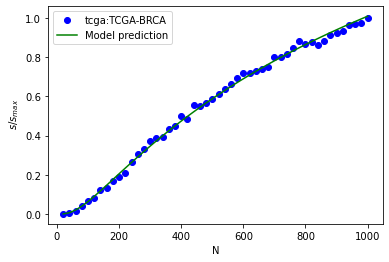

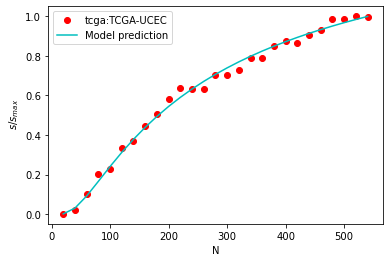

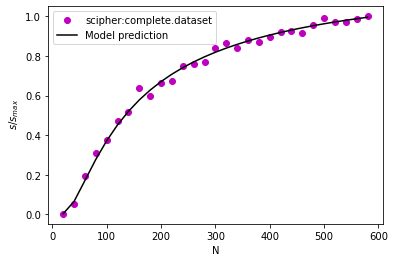

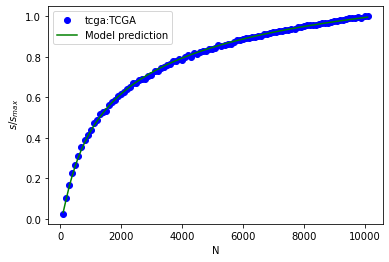

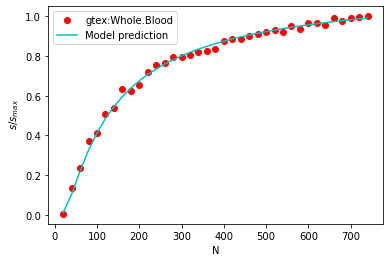

In [17]:
dataset=set(df.dataset)
sample_number=set(df.rep)      
plt.figure()

for data in dataset:
    n_samples_l=[]
    sign_edges_l=[]      
    for sample in sample_number:
        data_bool=df.dataset==data
        sample_bool=df.rep==sample
        current=df[data_bool&sample_bool]
        sign_edges_l.append(current.num_edges)
        n_samples_l.append(current['size'])

    # Calculate mean of samples and mean of significant edges for each sample size
    normx=np.mean(n_samples_l,axis=0)
    normy=np.mean(sign_edges_l,axis=0)

    plt.figure()
    # Find smax and linear fit from smax
    smax,res=find_s_max(normy/np.max(normy),normx)
    # Get coefficients from linear fit of smax
    a=res.slope
    b=res.intercept
    # Calculate values of y using the optimized smax (y is the same as s)
    y=np.exp(np.log(smax)-np.exp(b+a*np.log(normx)))
    # Calculate fraction y/smax
    percent=y/smax
    print(data, smax ,np.max(normy)/max(percent)/((20000)**2/2))# Predicting the fractions. Fraction = max value of s / total num of edges in complete graph
    # Plot sample size vs normalized s
    plt.plot(normx,normy/np.max(normy),'o',label=data,c=next(cycol))
    # Plot sample size vs prediction of s
    plt.plot(normx,y,'-',c=next(cycol),label='Model prediction')
    plt.legend()
    plt.ylabel(r' $s/s_{max}$')
    plt.xlabel('N')



In [11]:
normy

array([  123524.6,  1488841.4,  7202167.6, 14511117. , 16315373.6,
       24249514.6, 26654575.4, 31907504.8, 36305187.4, 42054696.4,
       46046428.2, 45383259.4, 45518983. , 50549961.8, 50632831.8,
       52271915. , 56957642.2, 56976271.6, 61316332. , 63111241.2,
       62306712.2, 65172142. , 67014501.4, 71050026. , 70986404.2,
       71983754.4, 71634579.6])

In [12]:
normx

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.,
       240., 260., 280., 300., 320., 340., 360., 380., 400., 420., 440.,
       460., 480., 500., 520., 540.])

In [13]:
res

LinregressResult(slope=-0.7905116810384566, intercept=4.298613423104628, rvalue=-0.9974670475972611, pvalue=3.169429571029762e-30, stderr=0.011274390068217979, intercept_stderr=0.06144138369026198)